In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
from sklearn.metrics import jaccard_score
import random
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression


from sklearn.decomposition import PCA #for cluster analysis
from gensim.models import KeyedVectors #for word embeddings
import matplotlib.pyplot as plt #for plotting
import os #for importing
import pickle #for loading transcripts
from scipy.stats import pearsonr 

# from _DRAFT_20200604_functions import * #includes constants and score function
from tqdm import tqdm_notebook #for progress bar

%autosave 5

Autosaving every 5 seconds


# 0. Importing story and template vectors and sums 

In [2]:
templates = pickle.load( open( 'template_vc', "rb" ) )
stories = pickle.load( open( 'story_vc', "rb" ) )
# sums
sums = pickle.load( open( "new_sums", "rb" ) )

# I. AVERAGING WEIGHTS
## A. get recall averages across different priming groups

In [27]:
story_order = [11,12,13,14,21,22,23,24,31,32,33,34,41,42,43,44]
story_avg = {}

for key in story_order:
    # Loop through all conditions
    for i in range(0, 3):
        if i == 0:
            story_avg[key] ={i: np.mean(stories[key][i], axis = 0)}
        else:    
            story_avg[key][i] = np.mean(stories[key][i], axis = 0)

## B. Linear Regression

In [74]:
coef = {0: np.zeros((16,2)), 1: np.zeros((16,2)), 2: np.zeros((16,2))}
count = 0

for key in story_avg:
    loc = key%10
    soc = round(key/10)*10
    # Make the inputs of the regression
    l_temp = templates[loc].reshape(templates[loc].shape[0],-1)
    s_temp = templates[soc].reshape(templates[soc].shape[0],-1)
    inputs = np.concatenate((l_temp, s_temp), axis = 1)
    for i in range(0, 3):
        output = story_avg[key][i]
        model = LinearRegression().fit(inputs, output)
        coef[i][count] = model.coef_
    count += 1

## C. Avg across weights for each priming type and plot

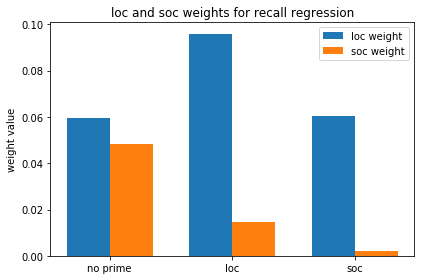

In [75]:
# loc weight
w0 = np.zeros((3,1))

# soc weight
w1 = np.zeros((3,1))

# assign values
w0[0] = np.mean(coef[0], axis = 0)[0]
w1[0] = np.mean(coef[0], axis = 0)[1]
w0[1] = np.mean(coef[1], axis = 0)[0]
w1[1] = np.mean(coef[1], axis = 0)[1]
w0[2] = np.mean(coef[2], axis = 0)[0]
w1[2] = np.mean(coef[2], axis = 0)[1]

w0 = w0.ravel()
w1 = w1.ravel()

#labels
labels = ['no prime', 'loc', 'soc']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, w0, width, label='loc weight')
rects2 = ax.bar(x + width/2, w1, width, label='soc weight')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('weight value')
ax.set_title('loc and soc weights for recall regression')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

plt.show()




# II. CONCATENATING
## A. concat templates vecs and story avgs

In [80]:
story_order = [11,12,13,14,21,22,23,24,31,32,33,34,41,42,43,44]
concat_story_avg = {0: np.zeros((0,1)), 1: np.zeros((0,1)), 2: np.zeros((0,1))}

inputs = np.zeros((0,2))

for key in story_order:
    # story avgs
    # Loop through all conditions
    for i in range(0, 3):
        this_story = story_avg[key][i].reshape(story_avg[key][i].shape[0],-1)
        concat_story_avg[i] = np.concatenate((concat_story_avg[i], this_story), axis = 0)
    # concatenating template vectors
    loc = key%10
    soc = round(key/10)*10
    # Make the inputs of the regression
    l_temp = templates[loc].reshape(templates[loc].shape[0],-1)
    s_temp = templates[soc].reshape(templates[soc].shape[0],-1)
    this_input = np.concatenate((l_temp, s_temp), axis = 1)
    inputs = np.concatenate((inputs, this_input), axis =0)

## B. Linear Regression

In [88]:
w0_c = np.zeros((3,1))
w1_c = np.zeros((3,1))

for i in range(0,3):
    model = LinearRegression().fit(inputs, concat_story_avg[i])
    w0_c[i] = model.coef_[0][0]
    w1_c[i] = model.coef_[0][1]
    


## C.Plotting

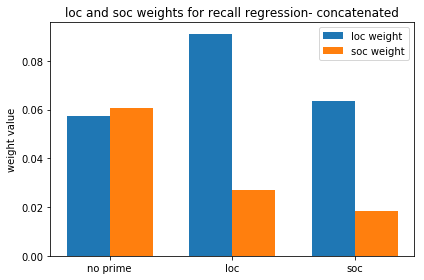

In [91]:
#labels
labels = ['no prime', 'loc', 'soc']

w0_c = w0_c.ravel()
w1_c = w1_c.ravel()


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, w0_c, width, label='loc weight')
rects2 = ax.bar(x + width/2, w1_c, width, label='soc weight')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('weight value')
ax.set_title('loc and soc weights for recall regression- concatenated')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

plt.show()
